In [1]:
from graphviz import Graph
import numpy as np
from ortools.linear_solver import pywraplp

# 3 node levels: A, B, C
# intra-class weights
A = {
    (0, 1): 5,
    (0, 2): -5,
    (1, 2): -5
}

B = {
    (0, 1): 5,
    (0, 2): 5,
    (1, 2): 5
}

C = {
    (0, 1): 0
}

# inter-class weights
W1 = {
    (0, 0): 5,
    (0, 1): 5,
    (0, 2): -5,
    (1, 0): 5,
    (1, 1): 5,
    (1,2): -5,
    (2,0): -5,
    (2,1):-5,
    (2, 2): 5
}

W2 = {
    (0, 0): 5,
    (0, 1): 5,
    (1, 0): -5,
    (1, 1): 5,
    (2, 0): -5,
    (2, 1): 5
}

get = lambda M, i, j: M[(min(i,j), max(i,j))]
shape = lambda M: (np.max(np.array(list(M.keys()))[:,0]) + 1, \
                np.max(np.array(list(M.keys()))[:,1]) + 1)

Limb_weights = [W1, W2]
Limbs = [(0, 1), (1, 2)]
Joints = [A, B, C]


solver = pywraplp.Solver('SolveAssignmentProblemMIP',
                               pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

Lambda = {}
Iota = {}
Iota_handled = set()
Sums = []

for lid, (W, (a,b)) in enumerate(zip(Limb_weights, Limbs)):
    
    lm_pairs = []
    io1_pairs = []
    io2_pairs = []
    J_a = Joints[a]
    J_b = Joints[b]
    
    n,m = shape(W)
    lm = {}
    for i in range(n):
        for j in range(m):
            Lambda[lid,i,j] = solver.BoolVar('lm%i[%i,%i]' % (lid,i,j))
            lm_pairs.append((i,j))
    
    is_a_handled = a in Iota_handled
    if not is_a_handled:
        Iota_handled.add(a)
        for i in range(n):
            for j in range(n):
                if i == j:
                    continue
                Iota[a,i,j] = solver.BoolVar('iota%i[%i,%i]' % (a,i,j))
                io1_pairs.append((i,j))
                    
    is_b_handled = b in Iota_handled
    if not is_b_handled:
        Iota_handled.add(b)
        for i in range(m):
            for j in range(m):
                if i == j:
                    continue
                Iota[b,i,j] = solver.BoolVar('iota%i[%i,%i]' % (b,i,j))
                io2_pairs.append((i,j))
    
    for i in range(n):
        for j in range(n):
            for k in range(m):
                q1 = (lid, i, k) in Lambda
                q2 = (lid, j, k) in Lambda
                q3 = (a, i, j) in Iota
                if q1 and q2 and q3:
                    solver.Add(Lambda[lid, i, k] + Lambda[lid, j, k] - 1 <= Iota[a, i, j])
                    solver.Add(Lambda[lid, i, k] + Iota[a, i, j] - 1 <= Lambda[lid, j, k])
    
    for i in range(m):
        for j in range(m):
            for k in range(n):
                q1 = (lid, k, i) in Lambda
                q2 = (lid, k, j) in Lambda
                q3 = (b, i, j) in Iota

                if q1 and q2 and q3:
                    solver.Add(Lambda[lid, k, i] + Lambda[lid, k, j] - 1 <= Iota[b, i, j])
                    solver.Add(Lambda[lid, k, i] + Iota[b, i, j] - 1 <= Lambda[lid, k, j])

    sum_lambda = solver.Sum(
            Lambda[lid, i,j] * W[i,j] for i,j in lm_pairs)
    Sums.append(sum_lambda)
    
    if not is_a_handled:
            sum_A = solver.Sum(
                Iota[a,i,j] * get(J_a,i,j) for i,j in io1_pairs)
            Sums.append(sum_A)
    
    if not is_b_handled:
            sum_B = solver.Sum(
                Iota[b,i,j] * get(J_b,i,j) for i,j in io2_pairs)
            Sums.append(sum_B)

solver.Maximize(sum(Sums))
solver.Solve()
print("Time = ", solver.WallTime(), " ms")
                    
                    
print('--')

Time =  18  ms
--


In [2]:
def draw_graph(Limb_weights, Limbs, Unaries=None):
    g = Graph('G', engine='dot')


    Jname = ['A', 'B', 'C']
    Y_pos = [10, 5, 0]
    Y_drift = [1, 0, 1]
    drawn_joints = set()

    for W, (a,b) in zip(Limb_weights, Limbs):
        J_a = Joints[a]
        J_b = Joints[b]

        for jid, Jj in zip([a,b], [J_a, J_b]):
            if jid not in drawn_joints:
                drawn_joints.add(jid)
                for (i, j), value in Jj.items():
                    pos_i = str(i*2) + ',' + str(Y_pos[jid]+Y_drift[i]) + "!"
                    pos_j = str(j*2) + ',' + str(Y_pos[jid]+Y_drift[j]) + "!"
                    if Unaries is None:
                        g.node(Jname[jid] + str(i), pos=pos_i)
                        g.node(Jname[jid] + str(j), pos=pos_j)
                    else:
                        u_i = Unaries[jid][i]
                        u_j = Unaries[jid][j]
                        
                        h = hex(int(u_i * 255))
                        color_i = "#" + h + h + h
                        
                        h = hex(int(u_j * 255))
                        color_j = "#" + h + h + h
                        
                        g.node(Jname[jid] + str(i), pos=pos_i, 
                               fontcolor=color_i)
                        g.node(Jname[jid] + str(j), pos=pos_j,
                              fontcolor=color_i)

                    if value > 0:
                        g.edge(Jname[jid] + str(i), Jname[jid] + str(j),
                              penwidth=str(value),color='#339966')
                    elif value < 0:
                        g.edge(Jname[jid] + str(i), Jname[jid] + str(j),
                              penwidth=str(-value),color='#ff6600')
                    else:
                        g.edge(Jname[jid] + str(i), Jname[jid] + str(j),
                              penwidth="1",color='#666699')

        for (i, j), value in W.items():
            if value > 0:
                g.edge(Jname[a] + str(i), Jname[b] + str(j),
                      penwidth=str(value), color='#99cc00')
            elif value < 0:
                g.edge(Jname[a] + str(i), Jname[b] + str(j),
                      penwidth=str(-value), color='#ff5050')
            else:
                g.edge(Jname[a] + str(i), Jname[b] + str(j),
                      penwidth=str(1), color='#c5dee2')


    g.save('wgraph.dot')
    
draw_graph(Limb_weights, Limbs)

In [3]:
# dot -Kfdp -n -Tpng -o graph.png wgraph.dot && dot -Kfdp -n -Tpng -o egraph.png egraph.dot

g = Graph('G', engine='dot')


Jname = ['A', 'B', 'C']
Y_pos = [10, 5, 0]
Y_drift = [1, 0, 1]
drawn_joints = set()

for lid, (W, (a,b)) in enumerate(zip(Limb_weights, Limbs)):
    J_a = Joints[a]
    J_b = Joints[b]
    
    for jid, Jj in zip([a,b], [J_a, J_b]):
        if jid not in drawn_joints:
            drawn_joints.add(jid)
            for (i, j), value in Jj.items():
                g.node(Jname[jid] + str(i), pos=str(i*2) + ',' + str(Y_pos[jid]+Y_drift[i]) + "!")
                g.node(Jname[jid] + str(j), pos=str(j*2) + ',' + str(Y_pos[jid]+Y_drift[j]) + "!")
                
                if Iota[jid, i, j].solution_value() > 0:
                    g.edge(Jname[jid] + str(i), Jname[jid] + str(j),
                          color='#666699')
            
    
    n, m = shape(W)
    for i in range(n):
        for j in range(m):
            if (lid, i, j) in Lambda:
                if Lambda[lid, i, j].solution_value() > 0:
                    g.edge(Jname[a] + str(i), Jname[b] + str(j))
    
    
    
    #Lambda
            

g.save('egraph.dot')

'egraph.dot'

In [4]:
import numpy as np
from ortools.linear_solver import pywraplp

A = [-1,  0,  1,  1,  -1]
B = [ 1, -1,  1]

solver = pywraplp.Solver('SolveAssignmentProblemMIP',
                               pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

Nu = {}
Sum = []

for jid, U in enumerate([A, B]):
    for idx, u in enumerate(U):
        Nu[jid, idx] = solver.BoolVar('nu[%i,%i]' %(jid, idx))
    
    s = solver.Sum(Nu[jid, idx] * u for idx, u in enumerate(U))
    Sum.append(s)

solver.Maximize(sum(Sum))
solver.Solve()

for key, var in Nu.items():
    print(str(key) + ' -> ' + str(var.solution_value()))

(0, 0) -> 0.0
(0, 1) -> 0.0
(0, 2) -> 1.0
(0, 3) -> 1.0
(0, 4) -> 0.0
(1, 0) -> 1.0
(1, 1) -> 0.0
(1, 2) -> 1.0


In [5]:
# import numpy as np
# from ortools.linear_solver import pywraplp

# Ua = [-1, 1]
# Ub = [-1, 1]

# A = np.array([
#     [ 0, -1],
#     [-1,  0]
# ])

# B = np.array([
#     [ 0, -1],
#     [-1,  0]
# ])

# L = np.array([
#     [ 1, -1],
#     [-1,  1]
# ])

# solver = pywraplp.Solver('SolveAssignmentProblemMIP',
#                                pywraplp.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

# n = A.shape[0]
# m = B.shape[0]

# Nu = {}

# for jid, (U, W) in enumerate(zip([Ua, Ub],[A, B])):
    
    
        

# disable outliers

Given a set of 3d points and a set of joints:

$$
X_j = \big\{ x_a^j \big\}_a^{n_j}, \ \ x_a^j \in \mathbb{R}^3, \ \ 
j \in \mathcal{J}
$$
with
$$
\mathcal{J} =  \{1, .., J\}
$$

as well as a set of limbs:

$$
L = \big\{ (j,\hat{j})_l \big\}_l, \ \ \ j,\hat{j} \in \mathcal{J}
$$

define edges between joints of the same class as follows:

$$
E_j = \big\{ 
(x_a^j, x_b^j) : a \neq b \wedge 
\vert\vert x_a^j - x_b^j \vert\vert_2^2 < \delta
\big\}
$$

where $\delta$ is a distance threshold (in $mm$) after which no connection is considered anymore.
Furthermore, define edges over limbs as follows:

$$
E_l = \big\{ 
(x_a^j, x_b^{\hat{j}}) : j \neq \hat{j} \wedge
(j, \hat{j}) \in L \wedge
\epsilon_{min}^l < \vert\vert x_a^j - x_b^{\hat{j}} \vert\vert_2^2
< \epsilon_{max}^l
\big\}$$

where $\epsilon_{min}^l, \epsilon_{max}^l$ represent the minimal/maximal length of a given limb $l$ (in $mm$).

Our graph $G=(D, E)$ is defined as follows:
$$
D = \bigcup_{j \in \mathcal{J}} X_j
$$
$$
E = E_j \ \cup \ E_l
$$

Now define 
* $\nu \in \{0, 1\}^{\vert D \vert}$, a binary variable that defines if a node is being removed or not
* $\lambda \in \{0, 1\}^{\vert E_l \vert}$, a binary variable that defines if a limb is removed or not
* $\iota \in \{0, 1\}^{\vert E_j \vert}$, a binary variable that defines if two nodes of the same joint type belong to the same candidate or not

A partitioning is obtained by maximizing the cost function:

$$
\underset{\nu, \lambda, \iota}{\mathrm{argmax}} 
\left \langle \nu, \phi \right \rangle + 
\left \langle \lambda, \Psi_{\lambda} \right \rangle + 
\left \langle \iota, \Psi_{\iota} \right \rangle
$$

with

$$
\left \langle \nu, \phi \right \rangle  = \sum_{d\in D} v_d \log \frac{p_d}{1-p_d}
$$

where $$p_d = \big(\frac{w_1^d + w_2^d}{2} + 
\frac{\exp[{-d_1}] + \exp[-d_2]}{2} \big) / 2 \\
=\frac{w_1^d + w_2^d + \exp[{-d_1}] + \exp[-d_2]}{4}
$$ and where $w_1^d, w_2^d \in (0, 1)$ are the belief that the detection is from the detected joint class. This values are given by the neural network and a single 3d point has two of them as it is triangulated from two views. $d_1$ and $d_2$ represent the distance of 
each 2d point that makes up the 3d point to the respective epipolar line. If the points fit prefectly then $d_1 =d_2 = 0$.

The limb costs $\left \langle \lambda, \psi_{\lambda} \right \rangle$ are defined as follows:

$$
\left \langle \lambda, \Psi_{\lambda} \right \rangle = 
\sum_{(x_a^j, x_b^{\hat{j}}) \in E_l} \lambda(x_a^j, x_b^{\hat{j}}) \psi_{\lambda}(x_a^j, x_b^{\hat{j}})
$$

with 
$$
\psi_{\lambda}(x_a^j, x_b^{\hat{j}}) = \log \biggr( 
\frac{p_\lambda(a, b)+1}{2 \big( \frac{1}{2} (-p_\lambda(a, b)-1) + 1\big)}
\biggr)
$$

where $p_\lambda(a, b) \in (-1, 1)$ defines the cost over the part affinity field of the given limb.

Last but not least we take a look at the formulation of the joint costs $\left \langle \iota, \Psi_{\iota} \right \rangle$ which simply linearly decreases with the distance between two points.

$$
\left \langle \iota, \Psi_{\iota} \right \rangle = \sum_{(x_a^j, x_b^j) \in E_{j}} \iota(x_a^j, x_b^j) \cdot \big( -\vert\vert x_a^j - x_b^j \vert\vert_2^2 \big)
$$

Several conditions have to be met for the optimization to yield valid results. First, it needs to be enured that only edges are considered when both nodes are valid:

$$
\lambda(a,b) \leq \nu(a) \wedge \lambda(a,b) \leq \nu(b) \ \ \ \ \forall (a,b) \in E_l
$$

$$
\iota(a,b) \leq \nu(a) \wedge \iota(a,b) \leq \nu(b) \ \ \ \ \forall (a,b) \in E_j
$$

Second, transitivity has to be enures:

$$
\lambda(a,c) + \lambda(b,c) -1 \leq \iota(a,b)
$$

$$
\lambda(a,c) + \iota(a,b) -1 \leq \lambda(b,c)
$$

$$
\iota(a,b) + \iota(a,c) -1 \leq \iota(b,c)
$$

In [6]:
import numpy as np
big_span = lambda x: np.log((x+1) / (2 * (0.5 * (-x -1)+1)))

small_span = lambda x: np.log(x/(1-x))

X = np.linspace(-0.99, 0.99, 100)
Y = [big_span(x) for x in X]

print('bigspan:', (np.min(Y), np.max(Y)))

X = np.linspace(0.001, 0.99, 100)
Y = [small_span(x) for x in X]

print('smallspan:', (np.min(Y), np.max(Y)))

bigspan: (-5.293304824724491, 5.293304824724491)
smallspan: (-6.906754778648554, 4.595119850134589)


In [7]:
from graphviz import Graph
import numpy as np
from ortools.linear_solver import pywraplp as mip

# 3 node levels: A, B, C
# intra-class weights
A = {
    (0, 1): 2,
    (0, 2): -4,
    (1, 2): -5
}

B = {
    (0, 1): -1,
    (0, 2): -6,
    (1, 2): -7
}

C = {
    (0, 1): -1
}

# inter-class weights
W1 = {
    (0, 0): 0.99,
    (0, 1): -0.3,
    (0, 2): -0.1,
    (1, 0): 0.6,
    (1, 1): 0.1,
    (1,2): -0.8,
    (2,0): -0.1,
    (2,1): 0.1,
    (2, 2): -0.1
}

W2 = {
    (0, 0): 0.3,
    (0, 1): 0.1,
    (1, 0): -0.01,
    (1, 1): 0.3,
    (2, 0): -0.4,
    (2, 1): -0.1
}

U_a = [0.6, 0.4, 0.5]
U_b = [0.6, 0.6, 0.3]
U_c = [0.9, 0.3]

get = lambda M, i, j: M[(min(i,j), max(i,j))]
shape = lambda M: (np.max(np.array(list(M.keys()))[:,0]) + 1, \
                np.max(np.array(list(M.keys()))[:,1]) + 1)

Limb_weights = [W1, W2]
Limbs = [(0, 1), (1, 2)]
Unaries = [U_a, U_b, U_c]
Joints = [A, B, C]


solver = mip.Solver('m', mip.Solver.CBC_MIXED_INTEGER_PROGRAMMING)

D = []
E_l = []
E_j = []

# --------

Nu = {}
Lambda = {}
Iota = {}

Sum = []

# ~~~ handle NU ~~~
for jid, U in enumerate(Unaries):
    for idx, u in enumerate(U):
        Nu[jid, idx] = solver.BoolVar('nu[%i,%i]' % (jid, idx))
        D.append((jid, idx))
        
    s = solver.Sum(
        Nu[jid, idx] * small_span(u) for idx, u in enumerate(U)
    )
    Sum.append(s)
    

# ~~~ handle intra-class ~~~
for jid, J in enumerate(Joints):
    for a, b in J.keys():
        Iota[jid, a, b] = solver.BoolVar('j[%i,%i,%i]' % (jid, a, b))
        E_j.append((jid, a, b))
    
    s = solver.Sum(
        Iota[jid, a, b] * J[a,b] for a,b in J.keys()
    )
    Sum.append(s)

# ~~~ handle inter-class ~~~
for lid, (W, (jid1, jid2)) in enumerate(zip([W1, W2], Limbs)):
    for a,b in W.keys():
        Lambda[jid1, jid2, a, b] = solver.BoolVar(
            'l[%i,%i,%i,%i]' % (jid1, jid2, a, b))
        E_l.append((jid1, jid2, a, b))
    
    s = solver.Sum(
        Lambda[jid1, jid2, a, b] * big_span(W[a,b]) for a,b in W.keys()
    )
    Sum.append(s)
    
# ~~~ handle conditions ~~~
for jid1, jid2, a, b in E_l:
    solver.Add(
        Lambda[jid1, jid2, a, b] <= Nu[jid1, a] and \
        Lambda[jid1, jid2, a, b] <= Nu[jid2, b]
    )

for jid, a, b in E_j:
    solver.Add(
        Iota[jid, a, b] <= Nu[jid, a] and \
        Iota[jid, a, b] <= Nu[jid, b]
    )


Trans = []
for jid1, jid2, a, b in E_l:
    pass


    
# ~~~ execute optimization ~~~
solver.Maximize(sum(Sum))
solver.Solve()
print("Time = ", solver.WallTime(), " ms")

for k, v in Nu.items():
    print(str(k) + '->' + str(v.solution_value()))
    
# ~~~ create clusters ~~~
valid_E_j = []
valid_E_l = []

for (jid1, jid2, a, b), v in Lambda.items():
    if v.solution_value() > 0:
        print(str(Nu[jid1,a]) + ' -> ' + str(Nu[jid2,b]))
        assert Nu[jid1, a].solution_value() > 0
        assert Nu[jid2, b].solution_value() > 0

Time =  4  ms
(0, 0)->1.0
(0, 1)->1.0
(0, 2)->1.0
(1, 0)->1.0
(1, 1)->1.0
(1, 2)->0.0
(2, 0)->1.0
(2, 1)->0.0
nu[0,0] -> nu[1,0]
nu[0,1] -> nu[1,0]
nu[0,1] -> nu[1,1]
nu[0,2] -> nu[1,1]
nu[1,0] -> nu[2,0]


JJ 6
LJ 10
[(0, 0, 1, 1, 0), (0, 0, 1, 1, 1), (0, 0, 2, 1, 0), (0, 0, 3, 1, 0), (0, 0, 1, 1, 0), (0, 0, 2, 1, 0), (0, 0, 3, 1, 0), (1, 0, 1, 0, 0), (0, 0, 1, 1, 1), (1, 1, 0, 0, 0)]


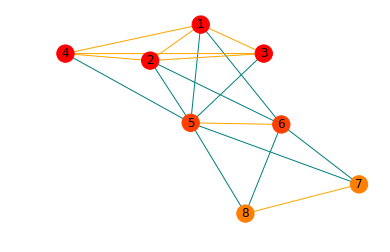

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import networkx as nx
import sys
sys.path.insert(0,'../')
from mvpose.candidates.transitivity import TransitivityLookup

# jid, id
D = [(0,0), (0,1),(0,2),(0,3),(1,0),(1,1),(2,0),(2,1)]

# jid1, jid2, a, b
E_l = [
    (0, 1, 0, 0),
    (0, 1, 0, 1),
    (0, 1, 1, 0),
    (0, 1, 1, 1),
    (0, 1, 2, 0),
    (0, 1, 3, 0),
    (1, 2, 0, 0),
    (1, 2, 0, 1),
    (1, 2, 1, 0),
    (1, 2, 1, 1)
]

# jid, a, b
E_j = [
    (0, 0, 1),
    (0, 0, 2),
    (0, 0, 3),
    (0, 1, 2),
    (0, 1, 3),
    (0, 2, 3),
    (1, 0, 1),
    (2, 0, 1)
] 
        
gr = TransitivityLookup(D, E_l, E_j)

JJ, LJ = gr.query(0, 0)

print("JJ", len(JJ))
print("LJ", len(LJ))

print(LJ)


plt.subplot(111)

gr.plot()